<a href="https://colab.research.google.com/github/murasakiw/ML2/blob/main/A3b_DL_TC5033_AD2023_text_classifier_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

### Team 15
- Héctor Raúl Vázquez González - A00565542
- Ronald David Zuniga Sánchez - A01686240
- Sergio Omar Esparza Hernández - A01794338
- Hugo Enrique Solano Ortega - A01794456

<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [36]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# Libraries to compute the confusion matrix and plot it
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [37]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Define the type of device that will be used to train the model
print(device) #Print the type of device available

cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [38]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [39]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [40]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [41]:
#test tokens
tokens = tokeniser('Welcome to TE3007') #Obtain tokens from text
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [42]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [43]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL]) #Split the training data set into two sets, one of them will be used for training and the other one for validation

In [44]:
#Print the total data for each data set
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [45]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [46]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [47]:
#Define dataloaders for each set of data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [48]:
EMBEDDING_SIZE = 300
NEURONS = 256 #Number of neurons of the recurrent network
LAYERS = 2 #Number of layers in the recurrent network
NUM_CLASSES = 4 #Number of categories

In this section we create the class that will contain all the layers of the model, and the function to compute the forward pass of the network. This model is made of three layers. The first layer is a embedding layer that is a lookup table that stores word embeddings and retrieve them using indices, so, this layer builds a dictionary using the elements in the vocab object and the size of the dictionary will have a size according to the number of elements in the the vocab object. In this layer it's also important to define the number of elements of each embedding vector. The next layer is a RNN type layer (RNN, GRU or LSTM). In this case we created two classes, in one of the classes we defined a simple RNN and in the other one we defined a GRU (Gated-Recurrent Unit) RNN. We did this to compare those RNN architectures and to see which one adapts better to the problem solved in this assignment. The last layer is a linear fully connected layer and it uses the last values of "y" in the RNN to predict the category of the analyzed text.

In [49]:
class RNN_Model_1(nn.Module): #Define the class considering a Recurrent Neural Network
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)
        # Parameters of the recurrent layer
        self.rnn = nn.RNN(input_size=embed_size,
                          hidden_size = hidden, #Number of neurons in the layer
                          num_layers = layers,  #Number of hidden layers
                          bidirectional = False,
                          batch_first=True)
                        # You may use PyTorch nn.GRU(), nn.RNN(), or nn.LSTM()
        # Complete output classifier layer using linear layer
        self.fc = nn.Linear(in_features=hidden, #Input is the number of layers in the recurrent layer
                            out_features=num_classes) #Output is the number of categories [0,1,2,3]

    def forward(self, x): #Define the forward pass
        y, h = self.rnn(self.embedding_layer(x)) #Forward pass to obtain the outputs of the recurrent layer
        return self.fc(y[:,-1]) #Return the output of the fully connected layer. We only need the last element of y
        # implement forward pass. This function will be called when executing the model

In [50]:
class GRU_Model_1(nn.Module): #Define the class considering a Gated Recurrent Unit
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)
        # Parameters of the model
        self.rnn = nn.GRU(input_size=embed_size,
                          hidden_size = hidden, #Number of neurons in the layer
                          num_layers = layers, #Number of hidden layers
                          bidirectional = False,
                          batch_first=True,
                          dropout=0.5) #Dropout to minimize overfitting
        # Complete output classifier layer using linear layer
        self.fc = nn.Linear(in_features=hidden, #Input is the number of layers in the recurrent layer
                            out_features=num_classes) #Output is the number of categories [0,1,2,3]

    def forward(self, x): #Define the forward pass
        y, h = self.rnn(self.embedding_layer(x)) #Forward pass to obtain the outputs of the recurrent layer
        return self.fc(y[:,-1]) #Return the output of the fully connected layer. We only need the last element of y
        # implement forward pass. This function will be called when executing the model

In [51]:
#Instantiate the model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES) #Using the rnn model
rnn_model #Display parameters of the model

RNN_Model_1(
  (embedding_layer): Embedding(95811, 300)
  (rnn): RNN(300, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [52]:
#Instantiate the model
gru_model = GRU_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES) #Using the gru model
gru_model #Display parameters of the model

GRU_Model_1(
  (embedding_layer): Embedding(95811, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In this section we define a function to calculate the accuracy of the model. This function takes the model and the data loader as parameters. In the function it is necessary to set the model object to evaluation mode because this function is called once the model has been trained completely or it can also be called at the last part in every training epoch to evaluate the model's throughput using the validation data set. In this function it is specified that it is not necessary to calculate the gradient, because we only need to obtain the predictions for each batch in the data set. This function obtains the correct predictions for every batch and it accumulates them in a variable. The total number of predictions made by the model are also stored in a variable. Finally we return the accuracy value by dividing the total number of correct samples by the number of total predictions made by the model.

In [53]:
def accuracy(model, loader): #Function to calculate accuracy
    model.eval() #Set the model to evaluation mode
    model = model.to(device=device) #Set the device to GPU
    correct_samples = 0 #Variable to store the number of correct predictions
    total_samples = 0 #Variable to store the number of total samples
    with torch.no_grad():
        for xi, yi in loader: #Loop through the data loader to obtain mini batches
            xi = xi.to(device=device, dtype = torch.long ) #Input data as torch tensors using GPU
            yi = yi.to(device=device, dtype = torch.long) #Labels as torch tensors using GPU
            scores = model(xi) #Obtain the ouput of the model
            correct_samples += (torch.argmax(scores, dim=1) == yi.squeeze()).sum() #Sum the total of correct samples of the minibatch and add the result to the variable
            total_samples += scores.size(0) #Obtain the total samples of the batch and add the result to the variable
    accuracy_value = float(correct_samples)/total_samples #Calculate the accuracy
    return accuracy_value

In this section we define a function to train the model, the function takes 3 parameters, the model object, the optimiser object and the number of epochs for which the model will be trained. We describe all the steps we followed to train the model with comments in the next code block. We used two lists to store the validation and train accuracies in order to plot them and to visualize the degree of overfitting in the model. In the last step, we calculate the validation and train accuracies and we define a condition to plot the results every 5 epochs and the result of the final iteration. The function returns the two lists with the training and validation accuracies so they can be used for plotting these results.

In [54]:
def train(model, optimiser, epochs=100): #Function to train the model
    model = model.to(device=device) #Set the device to GPU
    train_accuracies = list() #Define list to store the training accuracies
    val_accuracies = list() #Define list to store the validation accuracies
    train_cost = 0
    val_cost = 0
    for epoch in range(epochs): #Iterate the number of epochs to train the model
        model.train() #Set the model to training mode
        train_correct_samples = 0 #Variable to store the number of correct predictions
        train_total = 0 #Variable to store the number of total predictions
        train_cost_acum = 0
        for xi, yi in train_loader: #Loop through the data loader to obtain mini batches

            xi = xi.to(device=device, dtype = torch.long) #Input data as torch tensors using GPU
            yi = yi.to(device=device, dtype = torch.long) #Labels as torch tensors using GPU

            scores = model(xi) #Obtain the ouput of the model
            cost = F.cross_entropy(input=scores, target=yi) #Apply the cross_entropy function to calculate the cost
            optimiser.zero_grad() #Reset gradients to zero in order to not accumulate it
            cost.backward() #Calculate gradients with respect to all parameters of the model
            optimiser.step() #Update parameters considering the defined optimiser

            train_correct_samples += (torch.argmax(scores, dim=1) == yi.squeeze()).sum() #Sum the total of correct samples of the minibatch and add the result to the variable
            train_total += scores.size(0) #Obtain the total samples of the batch and add the result to the variable
        #Obtain the training and validation accuracies
        train_acc = float(train_correct_samples)/train_total
        val_acc = accuracy(model, val_loader)
        #Append the training and validation accuracies to each list
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        if epoch%5 == 0 or epoch == epochs: #If statement to plot the results every 5 epochs and the final result
            print(f'Epoch: {epoch}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')
    return train_accuracies, val_accuracies #Return lists with accuracies for each epoch

In [55]:
epochs = 20 #Set the number of epochs
lr = 0.001 #Set the learning rate
# instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES) #Instantiate the model using the rnn class
optimiser_rnn = torch.optim.Adam(rnn_model.parameters(), lr=lr) #Optimiser to minimize cost function


In [56]:
epochs = 20 #Set the number of epochs
lr = 0.001 #Set the learning rate
# instantiate model
gru_model = GRU_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES) #Instantiate the model using the gru class
optimiser_gru = torch.optim.Adam(gru_model.parameters(), lr=lr, weight_decay=1e-4) #Optimiser to minimize cost function

In [57]:
#Train the model and obtaining list with training and validation accuracies stored in them
train_accuracies_rnn, val_accuracies_rnn = train(rnn_model, optimiser=optimiser_rnn, epochs=epochs)

Epoch: 0, Train Accuracy: 0.3002, Validation Accuracy: 0.3078
Epoch: 5, Train Accuracy: 0.3534, Validation Accuracy: 0.3291
Epoch: 10, Train Accuracy: 0.3505, Validation Accuracy: 0.3473
Epoch: 15, Train Accuracy: 0.3605, Validation Accuracy: 0.3642


In [58]:
#Train the model and obtaining list with training and validation accuracies stored in them
train_accuracies_gru, val_accuracies_gru = train(gru_model, optimiser=optimiser_gru, epochs=epochs)

Epoch: 0, Train Accuracy: 0.7463, Validation Accuracy: 0.8862
Epoch: 5, Train Accuracy: 0.9337, Validation Accuracy: 0.9137
Epoch: 10, Train Accuracy: 0.9592, Validation Accuracy: 0.9193
Epoch: 15, Train Accuracy: 0.9729, Validation Accuracy: 0.9173


In this section we wrote some code to plot the validation and train accuracies obtained during training for every epoch and for each one of the models we defined previously. First we show the results for the RNN model and then we show the results for the GRU model.

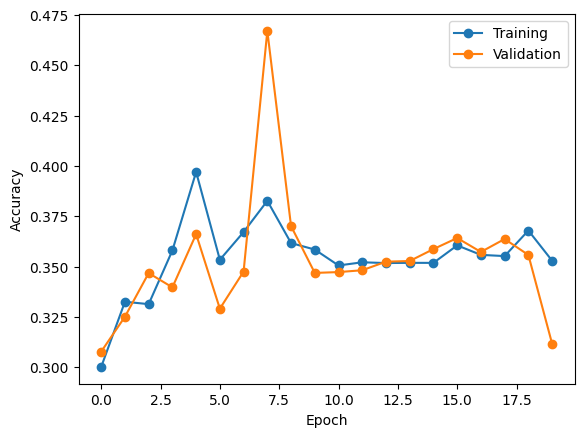

In [59]:
#Plot the accuracies for each epoch
fig, ax = plt.subplots()
ax.plot(train_accuracies_rnn, marker = 'o', linestyle='-', label='Training')#Plot training accuracies
ax.plot(val_accuracies_rnn, marker = 'o', linestyle='-', label='Validation')#Plot validation accuracies
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.show()


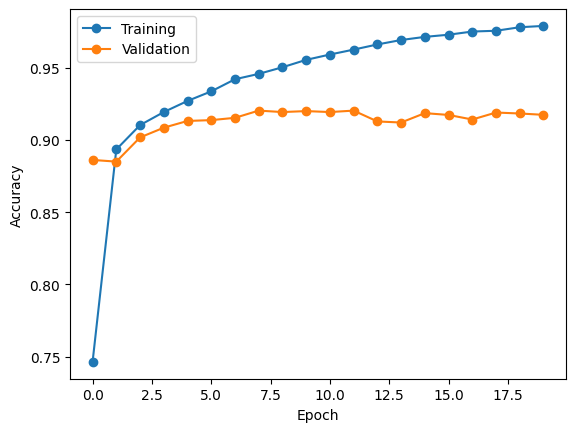

In [60]:
#Plot the accuracies for each epoch
fig, ax = plt.subplots()
ax.plot(train_accuracies_gru, marker = 'o', linestyle='-', label='Training')#Plot training accuracies
ax.plot(val_accuracies_gru, marker = 'o', linestyle='-', label='Validation')#Plot validation accuracies
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.show()

By looking at the GRU model validation and training accuracies, it is evident that there is some degree of overfitting in the model. We tried to compensate this by using a L2 regularization defining the "weight decay" parameter in the optimizer used for this model. We also added a dropout of 50% in the hidden layers in the RNN layer. We also observed that this model gets the highest accuracy for the validation data with only 8 epochs and after that the accuracy drops a little and the overfitting starts to rise. So, probably it is appropiate to stop the training at 8 or 9 epochs just to keep the overfitting from increasing so the model can generalize better.

In [61]:
print(f'The accuracy of the RNN model using test data: {accuracy(rnn_model, test_loader):.4f}')
print(f'The accuracy of the GRU model using test data: {accuracy(gru_model, test_loader):.4f}')

The accuracy of the RNN model using test data: 0.3038
The accuracy of the GRU model using test data: 0.9112


### Testing the model
---

In this section we obtain a prediction using the trained model for a random entry in the test data set. We also used a text we took from a news web page to test the model using from a current news story. We did this just to get an idea of how the model will respond  to data generated from a source that was not used for training the model and which corresponds to more recent events.


The "sample_text" function takes a random entry from the test set and returns the prediction made by the model.

In [62]:
def sample_text(model, loader):#Function to print the output of the model for a random text data
    labels_dict = {0:'World', 1:'Sports', 2:'Business', 3:'Sci/Tech'}
    random_index = np.random.randint(0, len(loader.dataset)) #Obtain random index to display a sample text
    y_true = loader.dataset[random_index][0] - 1 #Obtain the actual category of the sample minus 1 because the output categories of the model are 0,1,2,3
    x = loader.dataset[random_index][1] #Obtain the sample text
    tokens = tokeniser(x) #Obtain tokens list
    input = vocab(tokens) #Obtain data to feed the model
    model.eval() #Set the model to eval mode
    xi = torch.tensor(input) #Convert input data to torch tensor
    xi = xi.reshape(1,-1) #Reshape according to model input dimensions
    xi = xi.to(device=device, dtype = torch.long)
    scores = model(xi) #Obtain the scores by using the input data
    _, pred = scores.max(dim=1) #Obtain the predicted value
    y_pred = np.array(pred.cpu())[0] #Convert to numpy array an obtaining the first element which corresponds to the predicted category
    print(f'The sample text:\n{x}') #Print the sample text
    print(f'The category predicted by the model: {labels_dict[y_pred]}\nThe actual category: {labels_dict[y_true]}') #Print the predicted and the actual category

The "sample_text_1" function takes a text obtained from a news website and it returns the prediction.

In [63]:
def sample_text_1(model, text, category):#Function to print the output of the model for a given text data
    labels_dict = {0:'World', 1:'Sports', 2:'Business', 3:'Sci/Tech'} #Dictionary to assign numbers to labels
    x = text #Obtain the sample text
    tokens = tokeniser(x) #Obtain tokens list
    input = vocab(tokens) #Obtain data to feed the model
    model.eval() #Set the model to eval mode
    xi = torch.tensor(input) #Convert input data to torch tensor
    xi = xi.reshape(1,-1) #Reshape according to model input dimensions
    xi = xi.to(device=device, dtype = torch.long)
    scores = model(xi) #Obtain the scores by using the input data
    _, pred = scores.max(dim=1) #Obtain the predicted value
    y_pred = np.array(pred.cpu())[0] #Convert to numpy array an obtaining the first element which corresponds to the predicted category
    print(f'The sample text:\n{x}') #Print the sample text
    print(f'The category predicted by the model: {labels_dict[y_pred]}\nThe actual category: {category}') #Print the predicted and the actual category

In [64]:
sample_text(gru_model, test_loader) #Run the function

The sample text:
Gaddafi to Compensate Libyan Jews for Lost Homes (Reuters) Reuters - Libyan leader Muammar Gaddafi, easing\his country's way back into the international fold, on Tuesday\became the first Arab leader to promise compensation for Jews\who were forced from their homes due to religious tension.
The category predicted by the model: World
The actual category: World


In [65]:
text = "Israel admits attacking an ambulance in Gaza with the justification that it was used by Hamas"
sample_text_1(gru_model, text, "World") #Run the function to classify a given text

The sample text:
Israel admits attacking an ambulance in Gaza with the justification that it was used by Hamas
The category predicted by the model: World
The actual category: World


In [66]:
text = "He’s going to create his own lane’: Victor Wembanyama drops 38 points in Spurs win over the Phoenix Suns"
sample_text_1(gru_model, text, "Sports") #Run the function to classify a given text

The sample text:
He’s going to create his own lane’: Victor Wembanyama drops 38 points in Spurs win over the Phoenix Suns
The category predicted by the model: Sports
The actual category: Sports


### Confusion matrix

Finally, the last section it's about defining a function to create the confusion matrix of the model. In this case we used the scikitlearn confusion matrix function to calculate it. Then, the seaborn library was used for plotting the confusion matrix. Inside this function we wrote the code necessary to obtain the predicted values for all input elements in the data set. The function receives the model as a parameter, which is set to evaluation mode, then, the trained model is used to obtain the predicted values and finally, they are stored in a list. We also store the true output values in a list so we can use those lists to run the function to calculate the confusion matrix. Using the seaborn library we set the plot to show the results using an appropiate color map to observe the correct and incorrect predictions. We also set the labels for each axis to see more clearly which category the results correspond to.

In [67]:
# create confusion matrix
def plot_cm(model, loader):
    model.eval() #Set the model to evaluate mode
    y_true = list() #Define list to store the actual categories
    y_pred = list() #Define list to store the predicted categories by the model
    with torch.no_grad():
        for xi, yi in loader: #Loop through the data loader to obtain minibatches
            xi = xi.to(device=device, dtype = torch.long) #Input data as torch tensors using GPU
            yi = yi.to(device=device, dtype = torch.long) #Labels as torch tensors using GPU
            scores = model(xi) #Obtain the ouput of the model
            _, pred = scores.max(dim=1) #Obtain the predicted values
            predicted_vals = np.array(pred.cpu()) #Obtain the predicted values as numpy array
            labels = np.array(yi.cpu()) #Obtain the actual values as numpy array
            y_pred += list(predicted_vals) #Store data in the list
            y_true += list(labels) #Store data in the list
    labels_names = ['World', 'Sports', 'Business', 'Sci/Tech'] #Labels of each category
    cm = confusion_matrix(y_true, y_pred) #Obtain confusion matrix using scikitlearn
    ax = sns.heatmap(cm, cmap='coolwarm', cbar=False, fmt='', annot=True) #Plot the confusion matrix with seaborn
    ax.set(ylabel='y true labels', xlabel='y predicted labels', xticklabels = labels_names, yticklabels = labels_names) #Settings for the plot
    plt.show()

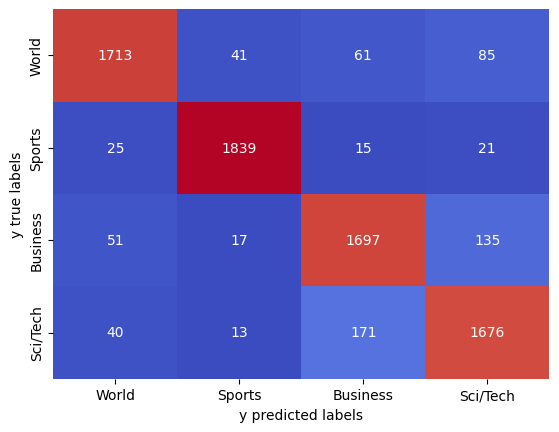

In [68]:
plot_cm(gru_model, test_loader) #Run function to display confusion matrix

We decided to compute the confusion matrix only for the prediction results obtained by using the model with the GRU layer in it, because it is the model with which the best results were obtained. By observing the results we can say that the categories in which the model makes the most mistakes in the predictions are Business and Sci/Tech. So, in order to improve the model, we should consider a way to help the model to differentiate better between those categories. One way could be to increase the number of samples in the data set, so the model can make better predictions. Considering the results showed in the confusion matrix, we decided to test the model using two texts from Business and Sci/Tech categories obtained from the internet. In this case we can see that the model made a mistake in the prediction for the first sample text.

In [69]:
text = "Monster Beverage completed the acquisition of Bang Energy from Vital Pharmaceuticals, Inc. on July 31 and in September launched Bang Energy in 12 single stock-keeping units (SKUs) and two multipack SKUs through Coca-Cola bottlers."
sample_text_1(gru_model, text, "Business") #Run the function to classify a given text

The sample text:
Monster Beverage completed the acquisition of Bang Energy from Vital Pharmaceuticals, Inc. on July 31 and in September launched Bang Energy in 12 single stock-keeping units (SKUs) and two multipack SKUs through Coca-Cola bottlers.
The category predicted by the model: Sci/Tech
The actual category: Business


In [70]:
text = "MIT engineers are on a failure-finding mission. The team’s new algorithm finds failures and fixes in all sorts of autonomous systems, from drone teams to power grids."
sample_text_1(gru_model, text, "Sci/Tech") #Run the function to classify a given text

The sample text:
MIT engineers are on a failure-finding mission. The team’s new algorithm finds failures and fixes in all sorts of autonomous systems, from drone teams to power grids.
The category predicted by the model: Sci/Tech
The actual category: Sci/Tech
